# Blauth-Arimotho Algorithm
Assuming X and Y as input and output variables of the channel respectively and r(x) is the input distributions. <br>
The capacity of a channel is defined by <br>
$C = \max_{r(x)} I(X;Y) = \max_{r(x)} \sum_{x} \sum_{y} r(x) p(y|x) \log \frac{r(x) p(y|x)}{r(x) \sum_{\tilde{x}} r(\tilde{x})p(y|\tilde{x})}$

In [1]:
import numpy as np


def blahut_arimoto(p_y_x: np.ndarray,  log_base: float = 2, thresh: float = 1e-12, max_iter: int = 1e3) -> tuple:
    '''
    Maximize the capacity between I(X;Y)
    p_y_x: each row represnets probability assinmnet
    log_base: the base of the log when calaculating the capacity
    thresh: the threshold of the update, finish the calculation when gettting to it.
    max_iter: the maximum iterations of the calculation
    '''

    # Input test
    assert np.abs(p_y_x.sum(axis=1).mean() - 1) < 1e-6
    assert p_y_x.shape[0] > 1

    # The number of inputs: size of |X|
    m = p_y_x.shape[0]

    # The number of outputs: size of |Y|
    n = p_y_x.shape[1]

    # Initialize the prior uniformly
    r = np.ones((1, m)) / m

    # Compute the r(x) that maximizes the capacity
    for iteration in range(int(max_iter)):

        q = r.T * p_y_x
        q = q / np.sum(q, axis=0)

        r1 = np.prod(np.power(q, p_y_x), axis=1)
        r1 = r1 / np.sum(r1)

        tolerance = np.linalg.norm(r1 - r)
        r = r1
        if tolerance < thresh:
            break

    # Calculate the capacity
    r = r.flatten()
    c = 0
    for i in range(m):
        if r[i] > 0:
            c += np.sum(r[i] * p_y_x[i, :] *
                        np.log(q[i, :] / r[i] + 1e-16))
    c = c / np.log(log_base)
    return c, r


# Example

## Binary symmetric channel
The BSC is a binary channel; that is, it can transmit only one of two symbols (usually called 0 and 1). <br>
The transmission is not perfect, and occasionally the receiver gets the wrong bit.  <br> 
The capacity of this channel  <br> 
$C = 1 - H_b(P_e)$

In [2]:
e = 0.2
p1 = [1-e, e]
p2 = [e, 1-e]
p_y_x = np.asarray([p1, p2])
C, r = blahut_arimoto(p_y_x)
print('Capacity: ', C)
print('The prior: ', r)

# The analytic solution of the capaciy
H_P_e = - e * np.log2(e) - (1-e) * np.log2(1-e)
print('Anatliyic capacity: ', (1 - H_P_e))


Capacity:  0.2780719051126379
The prior:  [0.5 0.5]
Anatliyic capacity:  0.2780719051126377


## Erasure channel
A binary erasure channel (or BEC) is a common communications channel.  <br> 
In this model, a transmitter sends a bit (a zero or a one), and the receiver either receives the bit or it receives a message that the bit was not received ("erased").  <br> 
The capacity of this channel is  <br> 
$C = 1 - P_e$.

In [3]:
e = 0.1
p1 = [1-e, e, 0]
p2 = [0, e, 1-e]
p_y_x = np.asarray([p1, p2])
C, r = blahut_arimoto(p_y_x, log_base=2)
print('Capacity: ', C)
print('The prior: ', r)

# The analytic solution of the capaciy
print('Anatliyic capacity: ', (1 - e))


Capacity:  0.9
The prior:  [0.5 0.5]
Anatliyic capacity:  0.9


# Converting to executable 
Create python file that could be imported to another file.

In [4]:
! jupyter nbconvert blahut_arimoto_algorithm.ipynb --to="python" --output-dir .

[NbConvertApp] Converting notebook blahut_arimoto_algorithm.ipynb to python
[NbConvertApp] Writing 6449 bytes to blahut_arimoto_algorithm.py


# Discrete the alphabet

In [5]:
from scipy.stats import norm

def discretize_alphabet(A, N, M):
    """
    Discretize the input and output alphabets for the Gaussian noise channel.

    Args:
    A (float): Peak amplitude constraint for the input.
    N (int): Number of intervals to discretize the input.
    M (int): Number of intervals to discretize the output.

    Returns:
    x (np.array): Discretized input alphabet.
    y (np.array): Discretized output alphabet.
    p_y_x (np.array): Conditional probability matrix P(Y|X).
    """
    # Discretize the input alphabet
    x = np.linspace(-A, A, N)

    # Estimate the range for the output alphabet and discretize it
    y = np.linspace(-A - 3, A + 3, M)

    # Initialize the conditional probability matrix
    p_y_x = np.zeros((M, N))

    # Calculate the conditional probabilities P(Y|X)
    for i in range(N):
        # For each discretized input, compute the distribution of the output
        p_y_x[:, i] = norm.pdf(y, loc=x[i], scale=1)

    # Normalize each column to ensure probabilities sum to 1
    p_y_x /= p_y_x.sum(axis=0, keepdims=True)

    return x, y, p_y_x

# AWGN

In [6]:
from matplotlib.pylab import randn
from numpy import sqrt


def awgn(input_signal, snr_dB, rate=1.0):
    """
    Addditive White Gaussian Noise (AWGN) Channel.

    Parameters
    ----------
    input_signal : 1D ndarray of floats
        Input signal to the channel.

    snr_dB : float
        Output SNR required in dB.

    rate : float
        Rate of the a FEC code used if any, otherwise 1.

    Returns
    -------
    output_signal : 1D ndarray of floats
        Output signal from the channel with the specified SNR.
    """

    avg_energy = sum(abs(input_signal) * abs(input_signal))/len(input_signal)
    snr_linear = 10**(snr_dB/10.0)
    noise_variance = avg_energy/(2*rate*snr_linear)

    if input_signal.dtype == complex:
        noise = (sqrt(noise_variance) * randn(len(input_signal))) + (sqrt(noise_variance) * randn(len(input_signal))*1j)
    else:
        noise = sqrt(2*noise_variance) * randn(len(input_signal))

    output_signal = input_signal + noise

    return output_signal

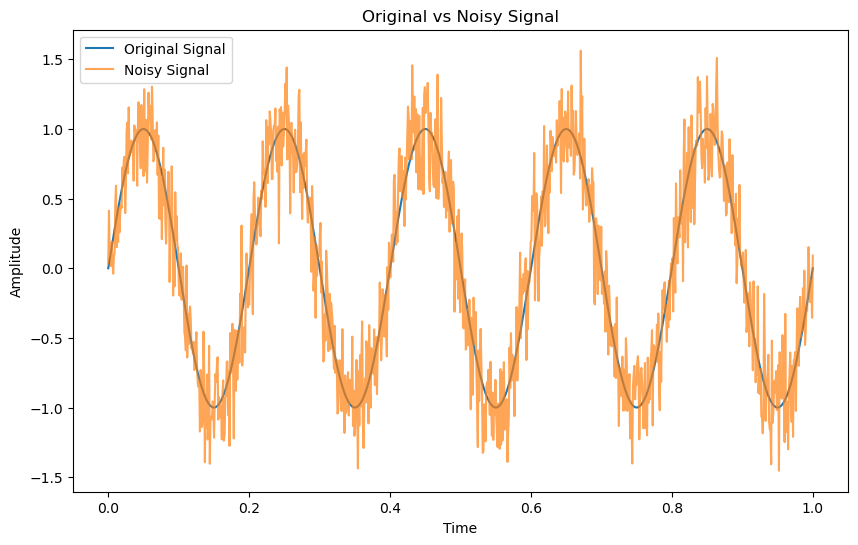

In [7]:
import matplotlib.pyplot as plt

# Generate a sample signal (e.g., a sinusoidal signal)
t = np.linspace(0, 1, 1000)  # Time vector
input_signal = np.sin(2 * np.pi * 5 * t)  # 5 Hz sine wave

# Add AWGN to the signal with a specific SNR
snr_dB = 10  # Signal-to-noise ratio in dB
noisy_signal = awgn(input_signal, snr_dB)

# Plot the original and noisy signals
plt.figure(figsize=(10, 6))
plt.plot(t, input_signal, label='Original Signal')
plt.plot(t, noisy_signal, label='Noisy Signal', alpha=0.7)
plt.title('Original vs Noisy Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Application

In [21]:
def discretize_input_output(A, num_points=100):
    X = np.linspace(-A, A, num_points)
    Y = np.linspace(-A - 3, A + 3, num_points)
    p_y_x = np.zeros((len(X), len(Y)))

    for i, x in enumerate(X):
        p_y_x[i, :] = norm.pdf(Y, loc=x, scale=1)
    p_y_x /= p_y_x.sum(axis=1, keepdims=True)

    return p_y_x

As = [0.1, 1, 10]
results = []

for A in As:
    p_y_x = discretize_input_output(A)
    capacity, distribution = blahut_arimoto(p_y_x)
    results.append(capacity)
    print("Capacity is", capacity, "when A equals", A)
    

Capacity is 0.002404891912380459 when A equals 0.1
Capacity is 0.21993695660141413 when A equals 1
Capacity is 2.4532223674307905 when A equals 10
